In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

## alexnet stuff

In [2]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)

## get embeddings of stims used in expt

In [3]:
# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials.csv')
# shape_files_used = trials_df['target_file'].tolist()
# embeddings = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# embeddings_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in embeddings])
# embeddings_df.columns = ['shapes'] + [f'feature_{i}' for i in range(embeddings_df.shape[1] - 1)]

# # append associated stim & noise positions
# embeddings_df['stim_file_pos'] = trials_df['stim_file_pos']
# embeddings_df['noise_pos'] = trials_df['noise_pos']
# reorder_columns = ['shapes', 'stim_file_pos', 'noise_pos'] + [col for col in embeddings_df.columns if col.startswith('feature_')]
# embeddings_df = embeddings_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# variances = embeddings_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# embeddings_df = embeddings_df.drop(columns=low_variance_features)

# embeddings_df.to_csv('../input_data/stimuli_embeddings.csv', index=False)

embeddings_df = pd.read_csv('../input_data/stimuli_embeddings.csv')
print(len(embeddings_df))
embeddings_df.head()


240


,shapes,stim_file_pos,noise_pos,feature_38,feature_45,feature_47,feature_52,feature_60,feature_88,feature_89,...,feature_3978,feature_3989,feature_4029,feature_4058,feature_4062,feature_4068,feature_4072,feature_4073,feature_4076,feature_4091
0,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
1,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
2,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
3,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
4,input_data/stims/Shape_0.50_1.00.png,0.5,1.0,0.0,5.420555,0.012235,10.232821,7.231481,1.283351,5.765145,...,1.027748,0.609162,16.070360,6.721252,0.987496,0.0,1.914770,5.642951,0.686270,0.0


## plot stim embeddings

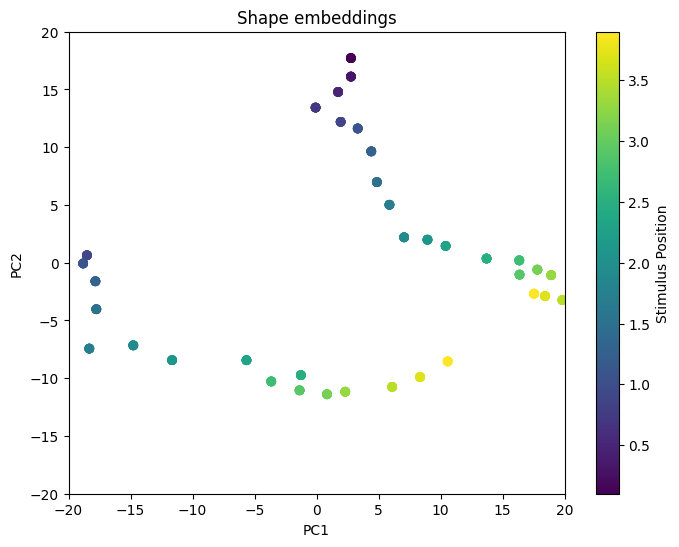

In [4]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_df.drop(columns=['shapes', 'stim_file_pos', 'noise_pos']))
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

reduced_embeddings_df['stim_file_pos'] = embeddings_df['stim_file_pos'].values
reduced_embeddings_df['noise_pos'] = embeddings_df['noise_pos'].values
reduced_embeddings_df.head()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['stim_file_pos'])
# scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['noise_pos'])
plt.colorbar(scatter, label='Stimulus Position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Shape embeddings')
plt.show()


## building architecture

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, output_dim)
        self.classification_output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # output for classification (binary)
        classification = torch.sigmoid(self.classification_output(x))
        
        return reconstruction, classification

## format input data

In [6]:
# cond_ids = list(range(40)) + list(range(120, 160))
# # cond_ids = list(range(40,80)) + list(range(160, 200))
# # cond_ids = list(range(80,120)) + list(range(200, 240))
# cond_div = 2 # 2/1/3

# # select feature cols and block (for now, divider in the middle) rows
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# cond_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

# X_train = cond_rows[feature_cols].values
# y_recon_train = X_train.copy()
# y_class_train = (cond_rows['stim_file_pos'] >= cond_div).astype(int).values # binary classification (0 or 1)
# print(type(X_train), type(y_recon_train), type(y_class_train))

# # Ensure data is a tensor
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_recon_train = torch.tensor(y_recon_train, dtype=torch.float32)
# y_class_train = torch.tensor(y_class_train, dtype=torch.float32).unsqueeze(1)  # Ensure y_class_train is of shape (N, 1) for binary classification

# print(X_train.shape, y_recon_train.shape, y_class_train.shape)

In [12]:
# select feature cols and block (for now, divider in the middle) rows
feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
block_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

X_train = block_rows[feature_cols].values
y_recon_train = X_train.copy()
y_class_train = (block_rows['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)
print(type(X_train), type(y_recon_train), type(y_class_train))
print(y_class_train)

# Ensure data is a tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_recon_train = torch.tensor(y_recon_train, dtype=torch.float32)
y_class_train = torch.tensor(y_class_train, dtype=torch.float32).unsqueeze(1)  # Ensure y_class_train is of shape (N, 1) for binary classification

print(X_train.shape, y_recon_train.shape, y_class_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
torch.Size([80, 405]) torch.Size([80, 405]) torch.Size([80, 1])


## train

### unreadable cross validation

In [13]:
# from sklearn.model_selection import KFold

# # # select feature cols and block (for now, divider in the middle) rows
# # feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# # block_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

# # X_train = block_rows[feature_cols].values
# # y_recon_train = X_train.copy()
# # y_class_train = (block_rows['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)
# # print(type(X_train), type(y_recon_train), type(y_class_train))

# # architecture params
# input_dim, hidden_dim, output_dim = 405, 128, 405
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 1, 5

# # convert to numpy arrays for compatibility with KFold
# X_train = np.array(X_train)
# y_recon_train = np.array(y_recon_train)
# y_class_train = np.array(y_class_train)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# # store losses for each fold
# all_total_losses, all_recon_losses, all_class_losses = [], [], []

# epochs = 100

# # cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
#     print(f"Fold {fold+1}")

#     # split into train and val
#     X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#     y_recon_train_fold, y_recon_val_fold = y_recon_train[train_idx], y_recon_train[val_idx]
#     y_class_train_fold, y_class_val_fold = y_class_train[train_idx], y_class_train[val_idx]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # store losses
#     total_train_losses, train_recon_losses, train_class_losses = [], [], []
#     total_val_losses, val_recon_losses, val_class_losses = [], [], []

#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass
#         recon_pred, class_pred = model(torch.tensor(X_train_fold, dtype=torch.float32))
#         class_pred = torch.sigmoid(class_pred)

#         # calculate losses
#         train_recon_loss = recon_loss_fn(recon_pred, torch.tensor(y_recon_train_fold, dtype=torch.float32))
#         train_class_loss = class_loss_fn(class_pred, torch.tensor(y_class_train_fold, dtype=torch.float32))
#         total_train_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization
#         optimizer.zero_grad()
#         total_train_loss.backward()
#         optimizer.step()

#         # store train losses
#         train_recon_losses.append(train_recon_loss.item())
#         train_class_losses.append(train_class_loss.item())
#         total_train_losses.append(total_train_loss.item())

#         # validation
#         model.eval()
#         with torch.no_grad():
#             recon_val_pred, class_val_pred = model(torch.tensor(X_val_fold, dtype=torch.float32))
#             class_val_pred = torch.sigmoid(class_val_pred)

#             # calculate val losses
#             val_recon_loss = recon_loss_fn(recon_val_pred, torch.tensor(y_recon_val_fold, dtype=torch.float32))
#             val_class_loss = class_loss_fn(class_val_pred, torch.tensor(y_class_val_fold, dtype=torch.float32))
#             total_val_loss = recon_wt * val_recon_loss + class_wt * val_class_loss

#             # store val losses
#             val_recon_losses.append(val_recon_loss.item())
#             val_class_losses.append(val_class_loss.item())
#             total_val_losses.append(total_val_loss.item())

#     print(f"Final Val Loss (Fold {fold+1}): Recon: {val_recon_losses[-1]}, Class: {val_class_losses[-1]}")

#     all_total_losses.append(total_val_losses)
#     all_recon_losses.append(val_recon_losses)
#     all_class_losses.append(val_class_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(all_total_losses[i], label=f'Fold {i+1} Total Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Validation Loss Curves (5-Fold)')
# plt.legend()
# plt.show()


### tryna make readable cross validation

In [14]:
# from sklearn.model_selection import KFold

# # # select feature cols and block (for now, divider in the middle) rows
# # feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# # block_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

# # X_train = block_rows[feature_cols].values
# # y_recon_train = X_train.copy()
# # y_class_train = (block_rows['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)
# # print(type(X_train), type(y_recon_train), type(y_class_train))

# # architecture params
# input_dim, hidden_dim, output_dim = 405, 128, 405
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 1, 5

# # convert to numpy arrays for compatibility with KFold
# X = np.array(X_train)
# y_recon = np.array(y_recon_train)
# y_class = np.array(y_class_train)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# # store losses for each fold
# all_total_losses, all_recon_losses, all_class_losses = [], [], []

# epochs = 100

# # cross-validation loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):
#     print(f"Fold {fold+1}")

#     # split into train and val
#     X_train, X_test = X[train_id],test_id[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id],test_id[test_id]
#     y_class_train, y_class_test = y_class[train_id],test_id[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # store losses
#     # total_losses, train_recon_losses, train_class_losses = [], [], []

#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # # store train losses
#         # train_recon_losses.append(train_recon_loss.item())
#         # train_class_losses.append(train_class_loss.item())
#         # total_train_losses.append(total_train_loss.item())

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             val_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             val_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             total_val_loss = recon_wt * val_recon_loss + class_wt * val_class_loss

#             # store val losses
#             test_recon_losses.append(val_recon_loss.item())
#             test_class_losses.append(val_class_loss.item())
#             test_total_losses.append(total_val_loss.item())

#     print(f"Final Val Loss (Fold {fold+1}): Recon: {test_recon_losses[-1]}, Class: {test_class_losses[-1]}")

#     all_total_losses.append(test_recon_losses)
#     all_recon_losses.append(test_recon_losses)
#     all_class_losses.append(test_class_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(all_total_losses[i], label=f'Fold {i+1} Total Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Validation Loss Curves (5-Fold)')
# plt.legend()
# plt.show()


### non-cross-validated training

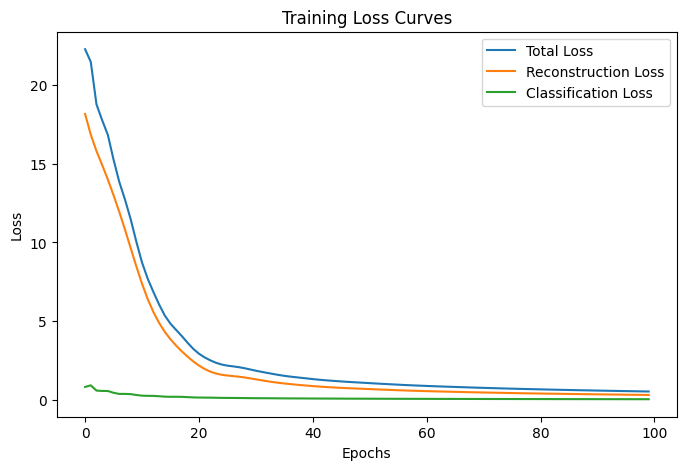

In [15]:
# store losses
total_train_losses, train_recon_losses, train_class_losses = [], [], []

# architecture params
input_dim, hidden_dim, output_dim = 405, 128, 405
model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# loss params
recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recon_wt, class_wt = 1, 5

# training loop
epochs = 100
for epoch in range(epochs):
    
    # forward pass
    recon_pred, class_pred = model(X_train)
    
    # calculate losses
    train_recon_loss = recon_loss_fn(recon_pred, y_recon_train)
    train_class_loss = class_loss_fn(class_pred, y_class_train)
    total_train_loss = recon_wt * train_recon_loss + class_wt * train_class_loss
    
    # store losses
    train_recon_losses.append(train_recon_loss.item())
    train_class_losses.append(train_class_loss.item())
    total_train_losses.append(total_train_loss.item())
    
    # backward pass and optimization
    optimizer.zero_grad()
    total_train_loss.backward()
    optimizer.step()

# plot losses
plt.figure(figsize=(8, 5))
plt.plot(total_train_losses, label='Total Loss')
plt.plot(train_recon_losses, label='Reconstruction Loss')
plt.plot(train_class_losses, label='Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

## visualize intermediate layer

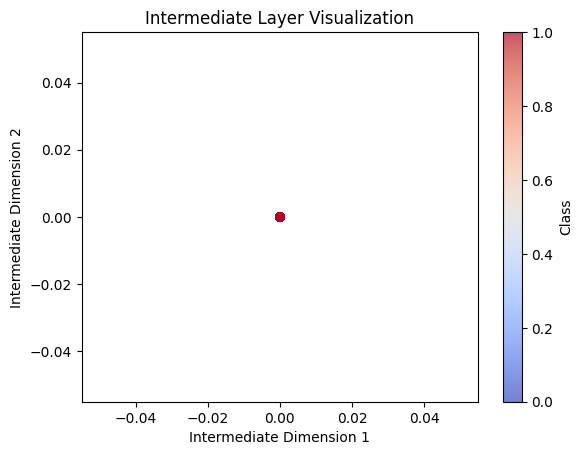

In [16]:
with torch.no_grad():
    intermediate_output = model.hidden(X_train)
    intermediate_output = F.relu(intermediate_output)

# Convert to numpy for visualization
intermediate_output_np = intermediate_output.numpy()

# Plot with class labels
plt.scatter(intermediate_output_np[:, 0], intermediate_output_np[:, 1], c=y_class_train, cmap='coolwarm', alpha=0.7)
plt.xlabel('Intermediate Dimension 1')
plt.ylabel('Intermediate Dimension 2')
plt.colorbar(label='Class')
plt.title('Intermediate Layer Visualization')
plt.show()


In [26]:
# 1. try just classification loss
# 2. try just reconstruction loss
# 3. try just asymmetric classification loss
# 4. try reconstruction + asymmetric loss
# 4. finally, remove asymmetry and add reward